# Q1

### 1.1 Dataset analysis & Pre Processing

In [1]:
import numpy as np
import pandas as pd

dat1 = pd.read_csv("./bin/WineQT.csv")
print(dat1.shape)
for i in dat1.columns:
    print(f"column {i}: ")
    column = dat1[i].to_numpy()
    print(f"mean = {np.mean(column)}",end=" ")
    print(f"std dev = {np.std(column)}",end=" ")
    print(f"min = {np.min(column)}",end=" ")
    print(f"max = {np.max(column)}")

(1143, 13)
column fixed acidity: 
mean = 8.311111111111112 std dev = 1.7468303726275016 min = 4.6 max = 15.9
column volatile acidity: 
mean = 0.5313385826771653 std dev = 0.17955459612835617 min = 0.12 max = 1.58
column citric acid: 
mean = 0.2683639545056868 std dev = 0.19659979421574741 min = 0.0 max = 1.0
column residual sugar: 
mean = 2.5321522309711284 std dev = 1.355324197143589 min = 0.9 max = 15.5
column chlorides: 
mean = 0.08693263342082239 std dev = 0.04724665655215518 min = 0.012 max = 0.611
column free sulfur dioxide: 
mean = 15.615485564304462 std dev = 10.246001115067605 min = 1.0 max = 68.0
column total sulfur dioxide: 
mean = 45.91469816272966 std dev = 32.76778677994138 min = 6.0 max = 289.0
column density: 
mean = 0.9967304111986001 std dev = 0.001924224834379527 min = 0.99007 max = 1.00369
column pH: 
mean = 3.3110148731408575 std dev = 0.15659551281704315 min = 2.74 max = 4.01
column sulphates: 
mean = 0.6577077865266842 std dev = 0.1703241580362606 min = 0.33 max 

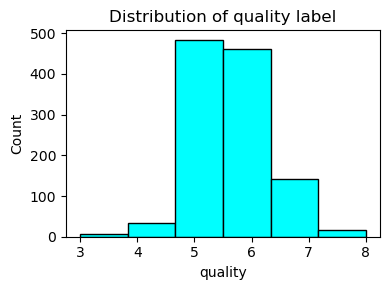

In [2]:
import matplotlib.pyplot as plt

labels_column = 'quality'
labels = dat1[labels_column]

plt.figure(figsize=(4, 3))
plt.hist(labels, bins=len(labels.unique()), edgecolor='black', color='cyan')
plt.title(f'Distribution of {labels_column} label')
plt.xlabel(labels_column)
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = dat1.drop(columns=['quality','Id']).to_numpy()
Y = dat1['quality'].to_numpy()

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Handle Missing or Inconsistent Data (if necessary)
# Use SimpleImputer to fill missing values with the mean or other strategies
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize and Standardize Data
# Use StandardScaler to standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


### 1.2: Model Building from Scratch

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

class MultinomialLogisticRegression:

    def __init__(self, num_features, num_classes, learning_rate=0.01, epochs=1000,printOutput=True):
        self.num_features = num_features
        self.num_classes = num_classes
        self.classes = None
        self.d = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W = np.random.rand(num_features, num_classes)
        self.b = np.zeros(num_classes)
        self.printOutput = printOutput

    def printMetrics(self,preds,true):
        print(f"Accuracy = \t {accuracy_score(preds,true)}")
        print(f"precision micro = \t {precision_score(preds,true,average='micro',zero_division=1)}",end="\t")
        print(f"precision macro = \t {precision_score(preds,true,average='macro',zero_division=1)}")
        print(f"recall micro = \t\t {recall_score(preds,true,average='micro',zero_division=1)}",end=" \t")
        print(f"recall macro = \t\t {recall_score(preds,true,average='macro',zero_division=1)}")
        print(f"f1_score micro = \t {f1_score(preds,true,average='micro',zero_division=1)}",end="\t")
        print(f"f1_score macro = \t {f1_score(preds,true,average='macro',zero_division=1)}\n")
        

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def cross_entropy_loss(self, oneHotTrueProbs, pred_probs):
        epsilon = 1e-15
        n = oneHotTrueProbs.shape[0]

        pred_probs = np.maximum(epsilon, pred_probs)
        loss = -np.sum(oneHotTrueProbs * np.log(pred_probs))
        
        return loss/n

    def gradient_descent(self, X, oneHotTrueProbs, pred_probs):
        n = oneHotTrueProbs.shape[0]
        dW = np.dot(X.T, (pred_probs - oneHotTrueProbs)) / n
        db = np.sum(pred_probs - oneHotTrueProbs) / n
        self.W -= self.learning_rate * dW
        self.b -= self.learning_rate * db
    
    def oneHotLabels(self, Y):
        oneHotTrueProbs = pd.get_dummies(Y).to_numpy()
        return oneHotTrueProbs

    def predict(self, X):
        n = X.shape[0]
        logits = np.dot(X, self.W) + self.b
        probabilities = self.softmax(logits)
        output = np.zeros(X.shape[0])
        for i in range(n):
            output[i] = self.d[np.argmax(probabilities[i])]
        return output

    def evaluate_wandb(self,X,Y):
        logits = X_train @ self.W + self.b
        probabilities = self.softmax(logits)
        oneHotY = self.oneHotLabels(Y_train)
        loss = self.cross_entropy_loss(oneHotY, probabilities)
        acc = accuracy_score(self.predict(X),Y)

        return loss, acc

    def fit(self, X_train, Y_train, X_val, Y_val):
        self.classes = np.zeros(self.num_classes)
        self.d = {}
        classes = np.unique(Y_train)
        for i in range (len(classes)):
            self.classes[i] = classes[i]
            self.d[i] = classes[i]

        for epoch in range(self.epochs):

            logits = X_train @ self.W + self.b
            probabilities = self.softmax(logits)

            oneHotY = self.oneHotLabels(Y_train)
            loss = self.cross_entropy_loss(oneHotY, probabilities)

            self.gradient_descent(X_train, oneHotY, probabilities)

            if (self.printOutput) and (epoch % 250 == 0):
                print(f'Epoch {epoch}: Loss = {loss}')

                predictions = self.predict(X_val)
                self.printMetrics(predictions, Y_val)

    

In [5]:
model = MultinomialLogisticRegression(num_features=X_train.shape[1], num_classes=len(np.unique(Y_train)))
model.fit(X_train, Y_train,X_val,Y_val)

Epoch 0: Loss = 2.406355163165565
Accuracy = 	 0.07602339181286549
precision micro = 	 0.07602339181286549	precision macro = 	 0.3133379795566175
recall micro = 		 0.07602339181286549 	recall macro = 		 0.06310050993022008
f1_score micro = 	 0.07602339181286549	f1_score macro = 	 0.2262302919165664

Epoch 250: Loss = 1.7571810668552643
Accuracy = 	 0.2631578947368421
precision micro = 	 0.2631578947368421	precision macro = 	 0.589979091995221
recall micro = 		 0.2631578947368421 	recall macro = 		 0.23973661473661476
f1_score micro = 	 0.2631578947368421	f1_score macro = 	 0.19503878775563224

Epoch 500: Loss = 1.5689632245529628
Accuracy = 	 0.3742690058479532
precision micro = 	 0.3742690058479532	precision macro = 	 0.39010022567370234
recall micro = 		 0.3742690058479532 	recall macro = 		 0.25648831376540293
f1_score micro = 	 0.37426900584795314	f1_score macro = 	 0.5474704052492355

Epoch 750: Loss = 1.5010880192917448
Accuracy = 	 0.45614035087719296
precision micro = 	 0.45614

In [6]:
predictions = model.predict(X_test)
model.printMetrics(predictions,Y_test)

Accuracy = 	 0.5
precision micro = 	 0.5	precision macro = 	 0.46640038731542005
recall micro = 		 0.5 	recall macro = 		 0.2624737529917918
f1_score micro = 	 0.5	f1_score macro = 	 0.5778724747474747



In [7]:
import wandb
import numpy as np

# Initialize W&B
wandb.init(project="SMAI_A3_q1-MultinomialLogisticRegression", entity="its_mrpsycho")

# Define a function to log to W&B
def log_to_wandb(loss, accuracy, learning_rate, epochs):
    wandb.log({
        "loss": loss,
        "accuracy": accuracy,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

# Hyperparameter Search
learning_rates = [0.01, 0.001, 0.0001]
epochs = [100, 200, 500, 1000, 1500]

for lr in learning_rates:
    for num_epochs in epochs:
        # Create and train your model with the current hyperparameters
        model = MultinomialLogisticRegression(num_features=X_train.shape[1], num_classes=len(np.unique(Y_train)), learning_rate=lr, epochs=num_epochs, printOutput=False)
        model.fit(X_train, Y_train, X_val, Y_val)

        # Evaluate on the validation set
        val_loss, val_accuracy = model.evaluate_wandb(X_val, Y_val)

        # Log the results to W&B
        log_to_wandb(val_loss, val_accuracy, lr, num_epochs)

# Analyze the results in the W&B dashboard


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: its_mrpsycho. Use `wandb login --relogin` to force relogin


In [8]:
import numpy as np
from sklearn.metrics import classification_report

modelOptimal = MultinomialLogisticRegression(num_features=X_train.shape[1], num_classes=len(np.unique(Y_train)), learning_rate=0.01, epochs=1500, printOutput=False)

modelOptimal.fit(X_train, Y_train, X_val, Y_val)
Y_pred = modelOptimal.predict(X_test)
report = classification_report(Y_test, Y_pred,zero_division=1)

print(report)

              precision    recall  f1-score   support

         3.0       0.00      1.00      0.00         0
         4.0       0.00      0.00      1.00         6
         5.0       0.70      0.74      0.72        81
         6.0       0.50      0.18      0.27        65
         7.0       0.28      0.76      0.41        17
         8.0       0.00      0.00      1.00         3

    accuracy                           0.49       172
   macro avg       0.25      0.45      0.57       172
weighted avg       0.55      0.49      0.53       172

